<a href="https://colab.research.google.com/github/kurkur19/Neural_networks_Al_Khmuz_BS_25/blob/main/10lab_NN_Al_Khmuz_BS_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ПРАКТИЧНА РОБОТА №10: РОЗРОБКА РЕКУРЕНТНОЇ НЕЙРОННОЇ МЕРЕЖІ


##Мета роботи:

Ознайомитися із принципами рекурентних нейронних мереж
(RNN), їхніми основними характеристиками та практичним застосуванням у
задачах обробки послідовностей.


Виконала студентка групи БС-25 Аль Хмуз Карина Бассамівна (1 варіант)

##*Теоретична частина*

***Рекурентні нейронні мережі (RNN)*** – це клас нейронних мереж, що були
безпосередньо розроблені для обробки послідовностей даних. Ці мережі названі
"рекурентними", тому що вони виконують ту саму задачу для кожного елемента
послідовності, зберігаючи при цьому інформацію про попередній елемент. Тобто,
вони мають "пам'ять", яка зберігає інформацію про те, що сталося раніше в
послідовності.


**Архітектура RNN: відмінності від традиційних нейронних мереж.**

1. Структура з петлями: Найбільша відмінність RNN від звичайних
нейронних мереж полягає в їх внутрішній структурі. У RNN є петлі, де
вихід з одного нейрона може бути входом для того самого нейрона в
наступному кроці часу. Ця петля дозволяє RNN зберігати інформацію.

2. Обробка послідовностей: Традиційні нейронні мережі приймають
фіксований розмір входу та видають фіксований розмір виходу, тоді як
RNN може працювати з послідовностями різної довжини.

3. Залежність від часу: Вихід RNN в даному часовому кроці залежить не
тільки від поточного входу, але й від попередніх входів. Ця "пам'ять" дає
можливість RNN враховувати контекст при обробці послідовностей.

4. Параметри: У традиційних нейронних мережах кожен шар може мати
свої ваги та зміщення. У RNN, ваги між нейронами, які з'єднуються з
петлями, зазвичай спільні на всіх часових кроках.

Ці основні відмінності роблять RNN вельми корисними для задач, де потрібно
враховувати контекст інформації або де дані подаються у вигляді
послідовностей, таких як розпізнавання мови, машинний переклад або
прогнозування часових рядів.

**Проблема зниклих (vanishing) та вибухових градієнтів (exploding gradients).**

- Під час навчання глибоких нейронних мереж, зокрема RNN, використовуються
градієнтні методи оптимізації. Однак, у рекурентних мережах при просуванні
градієнта назад у часі (backpropagation through time, BPTT) може статися, що
градієнти стають дуже малими (зниклий градієнт) або дуже великими (вибуховий
градієнт).

- Зниклий градієнт: Коли градієнти стають дуже малими, ваги мережі практично
не оновлюються, що призводить до того, що мережа не вчиться. Проблема
зниклих градієнтів особливо проблематична для RNN, коли потрібно "пам'ятати"
інформацію через довгі проміжки часу.

- Вибуховий градієнт: З іншого боку, коли градієнти стають дуже великими, вони
можуть призвести до нестабільності навчання або до неефективного оновлення
ваг. В таких випадках часто використовують техніку, яка називається "обрізання
градієнта" (gradient clipping), щоб вирішити цю проблему.


##*Практична частина*

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.layers import GRU

In [2]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Виведемо основну інформацію
print(f"Кількість навчальних прикладів: {len(x_train)}")
print(f"Кількість тестових прикладів: {len(x_test)}")

Кількість навчальних прикладів: 8982
Кількість тестових прикладів: 2246


In [4]:
# Переглянемо приклад тексту новини
word_index = reuters.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
decoded_news = " ".join([reverse_word_index.get(i - 3, "?") for i in x_train[0]])
print(f"Приклад тексту новини: {decoded_news}")

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Приклад тексту новини: ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [5]:
# Виведемо приклад мітки
print(f"Мітка прикладу: {y_train[0]}")

Мітка прикладу: 3


Дані завантажені успішно! Наступним кроком ми підготуємо дані для моделі. Ми перетворимо текстові дані в числові вектори та виконаємо one-hot-енкодинг міток.

###Крок №2 Підготовка даних

Векторизація тексту: Ми перетворимо послідовності індексів слів у вектори з однаковою довжиною, використовуючи pad_sequences.

One-hot-енкодинг міток: Мітки перетворюємо на категорійний формат для роботи з функцією втрат categorical_crossentropy.

In [7]:
# Векторизація текстових даних: усі послідовності мають однакову довжину
maxlen = 100  # Максимальна довжина послідовності
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# One-hot-енкодинг міток
y_train = to_categorical(y_train, num_classes=46)
y_test = to_categorical(y_test, num_classes=46)

# Виведемо форму даних для перевірки
print(f"x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (8982, 100)
x_test shape: (2246, 100)
y_train shape: (8982, 46)
y_test shape: (2246, 46)


pad_sequences: Зробили всі послідовності однакової довжини, щоб модель могла їх обробити. Якщо новина коротша, додаємо нулі; якщо довша — обрізаємо.

to_categorical: Перетворили мітки в формат one-hot. Наприклад, мітка 3 стане [0, 0, 0, 1, 0, ..., 0].

Дані підготовлені успішно, і ми готові переходити до створення нейронної мережі.



###Крок 3. Створення нейронної мережі

Модель матиме кілька шарів:

Вхідний шар для обробки текстових даних (embedding).

Схований шар (fully connected) для виявлення патернів.

Вихідний шар із 46 нейронами (по кількості категорій) з активацією softmax.

In [11]:
# Параметри моделі
vocab_size = 10000  # Розмір словника (максимальна кількість унікальних слів)
embedding_dim = 64  # Розмірність векторів для embedding-шару
input_length = 100  # Максимальна довжина послідовності

# Створення моделі
model = Sequential([
    # Embedding-шар для перетворення індексів слів у вектори
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(input_length,)),

    # LSTM шар для обробки послідовностей
    Bidirectional(LSTM(64)),

    # Вихідний шар
    Dense(46, activation='softmax')
])

# Компіляція моделі
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Виведення архітектури моделі
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,982 (2.72 MB)

 Trainable params: 711,982 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

###Крок 4. Тренування моделі

In [13]:
# Тренування моделі
history = model.fit(x_train, y_train,
                    epochs=5,  # кількість епох, можна збільшити для кращого результату
                    batch_size=64,  # розмір партії
                    validation_data=(x_test, y_test))  # для перевірки на тестових даних


Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.3580 - loss: 2.7209 - val_accuracy: 0.4969 - val_loss: 1.9548
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - accuracy: 0.5348 - loss: 1.8187 - val_accuracy: 0.5423 - val_loss: 1.7890
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.5495 - loss: 1.7260 - val_accuracy: 0.5232 - val_loss: 1.7509
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step - accuracy: 0.5872 - loss: 1.6011 - val_accuracy: 0.5739 - val_loss: 1.6506
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 143ms/step - accuracy: 0.6349 - loss: 1.3816 - val_accuracy: 0.6060 - val_loss: 1.5395


Наша модель ще не досягла високої точності, але це нормально, адже ми можемо працювати над її покращенням.

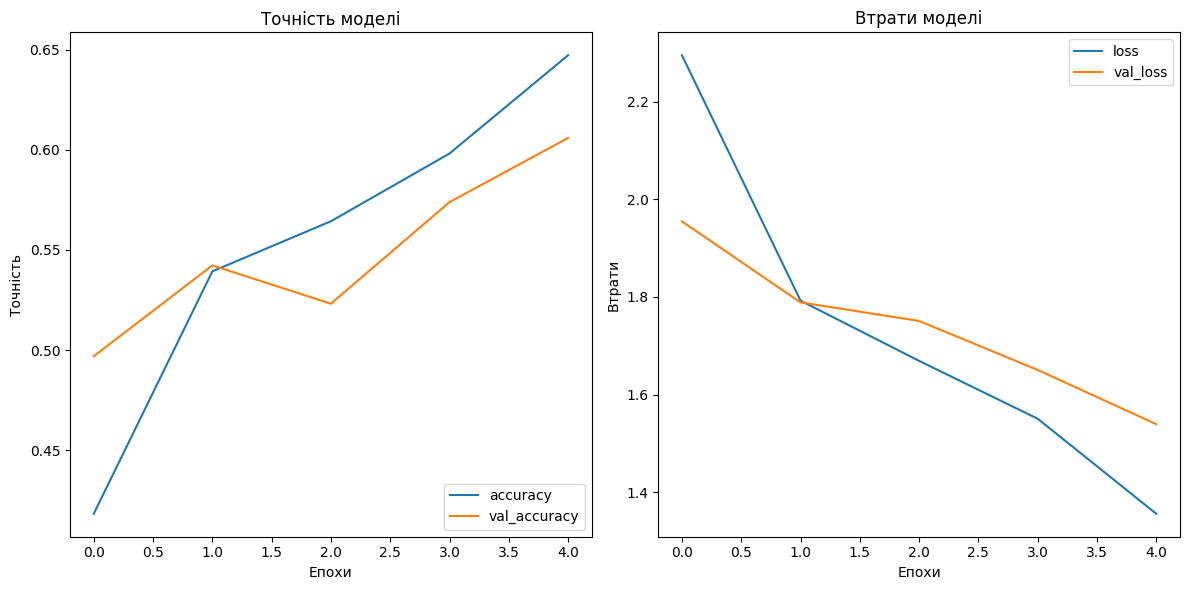

In [14]:
# Виведемо графіки точності та втрат
plt.figure(figsize=(12, 6))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.title('Точність моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend(loc='lower right')

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Втрати моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

***Опис графіків***

Графік точності: На графіку видно, що точність (accuracy) моделі зростає як для навчальних (train), так і для тестових (validation) даних із кожною епохою. Це свідчить про те, що модель поступово навчається розпізнавати патерни в даних. Однак приріст точності на валідаційних даних дещо повільніший, ніж на навчальних, що може вказувати на потребу у покращенні узагальнюючої здатності моделі.

Графік втрат: Втрата (loss) зменшується як на навчальних, так і на тестових даних, що свідчить про прогрес моделі у мінімізації помилок. Однак валідаційна втрата зменшується менш значно після перших епох, що може вказувати на недостатню складність моделі або потребу в додатковій регуляризації.

###Крок 5. Вдосконалення моделі

Ми додамо кілька вдосконалень:

Регуляризація: Додамо Dropout-шар для зменшення перенавчання.
Збільшення кількості нейронів: Збільшимо кількість нейронів у LSTM-шарі.
Збільшення кількості епох: Дамо моделі більше часу для навчання.


In [16]:
# Створення покращеної моделі
model_improved = Sequential([
    # Embedding-шар
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(input_length,)),

    # Bidirectional LSTM із регуляризацією Dropout
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),

    # Другий LSTM-шар для ускладнення моделі
    Bidirectional(LSTM(64)),
    Dropout(0.3),

    # Вихідний шар
    Dense(46, activation='softmax')
])

# Компіляція покращеної моделі
model_improved.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Виведення архітектури покращеної моделі
model_improved.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 100, 256)            │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,713,454 (6.54 MB)

 Trainable params: 1,713,454 (6.54 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Тренування покращеної моделі
history_improved = model_improved.fit(x_train, y_train,
                                      epochs=10,  # збільшимо кількість епох
                                      batch_size=64,
                                      validation_data=(x_test, y_test))


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 111s 747ms/step - accuracy: 0.3987 - loss: 2.5257 - val_accuracy: 0.5338 - val_loss: 1.7558
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 103s 730ms/step - accuracy: 0.5603 - loss: 1.6820 - val_accuracy: 0.5948 - val_loss: 1.6051
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 724ms/step - accuracy: 0.6428 - loss: 1.4101 - val_accuracy: 0.6331 - val_loss: 1.4757
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 735ms/step - accuracy: 0.7157 - loss: 1.1450 - val_accuracy: 0.6696 - val_loss: 1.3370
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 142s 733ms/step - accuracy: 0.7609 - loss: 0.9687 - val_accuracy: 0.6670 - val_loss: 1.3483
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 102s 725ms/step - accuracy: 0.7969 - loss: 0.8315 - val_accuracy: 0.6812 - val_loss: 1.3270
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 142s 727ms/step - accuracy: 0.8191 - loss: 0.7424 - val_accuracy: 0.6701 - val_loss: 1.3867
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 739ms/step - accuracy: 0.8463 -

Модель справді покращилась! Ми бачимо стабільний приріст точності, хоча валідаційна точність все ще може бути кращою.

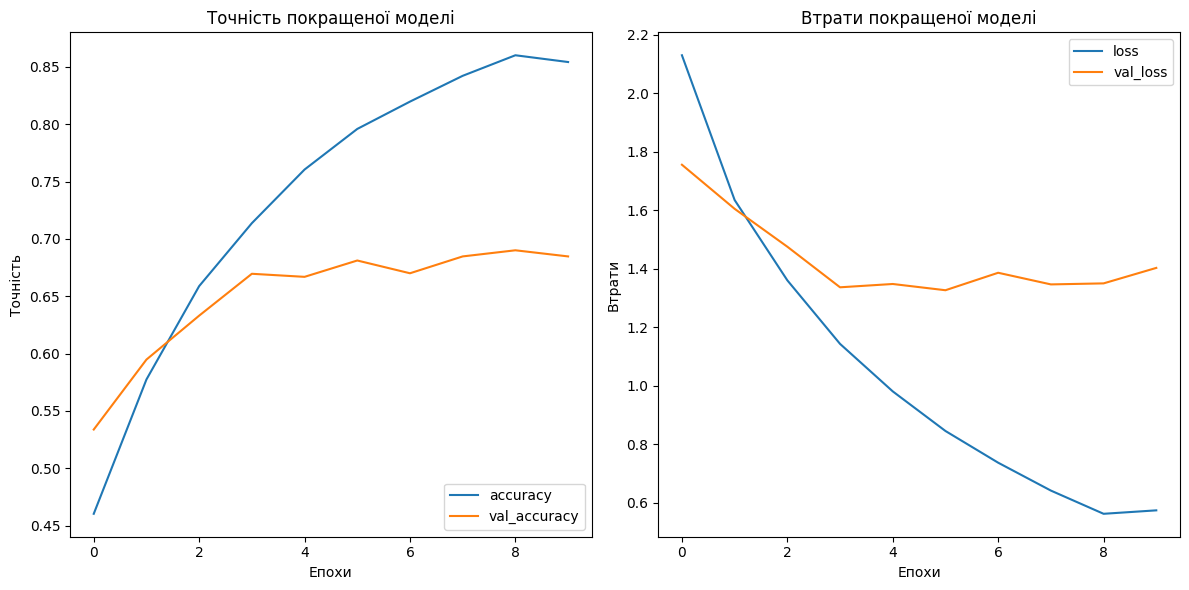

In [18]:
# Побудова графіків точності та втрат
plt.figure(figsize=(12, 6))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history_improved.history['accuracy'], label='accuracy')
plt.plot(history_improved.history['val_accuracy'], label='val_accuracy')
plt.title('Точність покращеної моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend(loc='lower right')

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history_improved.history['loss'], label='loss')
plt.plot(history_improved.history['val_loss'], label='val_loss')
plt.title('Втрати покращеної моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


**Опис графіків покращеної моделі**

Точність: Модель досягла точності 85% на навчальних даних і приблизно 69% на валідаційних. Видно, що модель навчається краще, але все ще має невелику різницю між навчальними та валідаційними даними, що може вказувати на можливе перенавчання.

Втрати: Втрати на навчальних даних значно зменшуються, однак валідаційні втрати після певного моменту залишаються стабільними або навіть трохи зростають. Це сигнал, що модель може "запам'ятовувати" дані замість узагальнення.

###Крок 6. Виведення метрик якості (F1, Precision, Recall)

Додамо розрахунок метрик якості для поточної моделі. Для цього скористаємось classification_report з бібліотеки sklearn.

In [20]:
# Прогнозування на тестових даних
y_pred = model_improved.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Отримуємо класи з one-hot енкодингу
y_test_classes = np.argmax(y_test, axis=1)  # Перетворюємо тестові мітки на класи

# Розрахунок метрик
report = classification_report(y_test_classes, y_pred_classes, target_names=[f"Class {i}" for i in range(46)])
print("Classification Report:")
print(report)


71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.19      0.25      0.21        12
     Class 1       0.59      0.68      0.63       105
     Class 2       0.37      0.35      0.36        20
     Class 3       0.88      0.93      0.90       813
     Class 4       0.81      0.78      0.80       474
     Class 5       0.00      0.00      0.00         5
     Class 6       0.38      0.71      0.50        14
     Class 7       0.50      0.33      0.40         3
     Class 8       0.38      0.55      0.45        38
     Class 9       0.48      0.64      0.55        25
    Class 10       0.55      0.70      0.62        30
    Class 11       0.58      0.48      0.53        83
    Class 12       0.00      0.00      0.00        13
    Class 13       0.27      0.22      0.24        37
    Class 14       0.00      0.00      0.00         2
    Class 15       0.00      0.00      0.00         9
    Class 16    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Аналіз метрик:**

**Точність (accuracy):** Загальна точність моделі становить 68%, що відповідає нашим попереднім спостереженням із графіків.

**F1-метрика, Precision, Recall:**

Макро-середнє: F1-метрика для всіх класів дорівнює 0.26, що вказує на низьку якість моделі для менш представлених класів. Макро-середнє враховує всі класи рівноправно, тому вплив рідкісних класів значний.

Зважене середнє: Зважене середнє F1 становить 0.67, що є більш позитивною оцінкою, оскільки часто зустрічаються класи (наприклад, 3 і 4) мають високі метрики.

**Проблеми з рідкісними класами:** Для класів із малою кількістю прикладів (наприклад, 5, 14, 17, 29) модель практично не дає результатів (precision = recall = 0). Це може бути результатом нерівномірного розподілу класів у датасеті.

###Крок 7. Порівняння з іншими архітектурами (GRU)

In [21]:
# Модель на основі GRU
model_gru = Sequential([
    # Embedding-шар
    Embedding(input_dim=vocab_size, output_dim=128, input_shape=(input_length,)),

    # GRU-шар
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(0.3),

    # Другий GRU-шар
    Bidirectional(GRU(64)),
    Dropout(0.3),

    # Вихідний шар
    Dense(46, activation='softmax')
])

# Компіляція моделі
model_gru.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Тренування GRU-моделі
history_gru = model_gru.fit(x_train, y_train,
                            epochs=10,
                            batch_size=64,
                            validation_data=(x_test, y_test))

# Виведення результатів GRU-моделі
y_pred_gru = model_gru.predict(x_test)
y_pred_classes_gru = np.argmax(y_pred_gru, axis=1)

report_gru = classification_report(y_test_classes, y_pred_classes_gru, target_names=[f"Class {i}" for i in range(46)])
print("Classification Report (GRU):")
print(report_gru)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 116s 778ms/step - accuracy: 0.3666 - loss: 2.6183 - val_accuracy: 0.5481 - val_loss: 1.7602
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 110s 778ms/step - accuracy: 0.5642 - loss: 1.6840 - val_accuracy: 0.5908 - val_loss: 1.6154
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 761ms/step - accuracy: 0.6472 - loss: 1.3569 - val_accuracy: 0.6202 - val_loss: 1.5012
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 782ms/step - accuracy: 0.7004 - loss: 1.1363 - val_accuracy: 0.6514 - val_loss: 1.4389
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 109s 776ms/step - accuracy: 0.7694 - loss: 0.9113 - val_accuracy: 0.6719 - val_loss: 1.3902
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 109s 777ms/step - accuracy: 0.8184 - loss: 0.7062 - val_accuracy: 0.6812 - val_loss: 1.4104
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 762ms/step - accuracy: 0.8568 - loss: 0.5648 - val_accuracy: 0.6670 - val_loss: 1.4698
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 143s 772ms/step - accuracy: 0.8826 - loss: 0.47

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


***Аналіз результатів для GRU-моделі***

Точність (Accuracy):

Загальна точність моделі на тестових даних складає 69%, що трохи краще, ніж у попередньої LSTM-моделі.

**F1-метрика, Precision, Recall:**

**Макро-середнє**: F1-метрика для всіх класів дорівнює 0.30, що краще, ніж у LSTM-моделі (0.26).

**Зважене середнє**: F1-метрика становить 0.68, приблизно на тому ж рівні, що й у LSTM-моделі.

Проблеми з рідкісними класами залишаються. Наприклад, деякі класи (наприклад, 14, 17, 29) мають precision = recall = 0, що свідчить про те, що модель взагалі їх не передбачає.

**Зростання val_loss:**

Починаючи з 6-ої епохи, val_loss почав зростати, а val_accuracy залишився на тому ж рівні. Це свідчить про перенавчання.

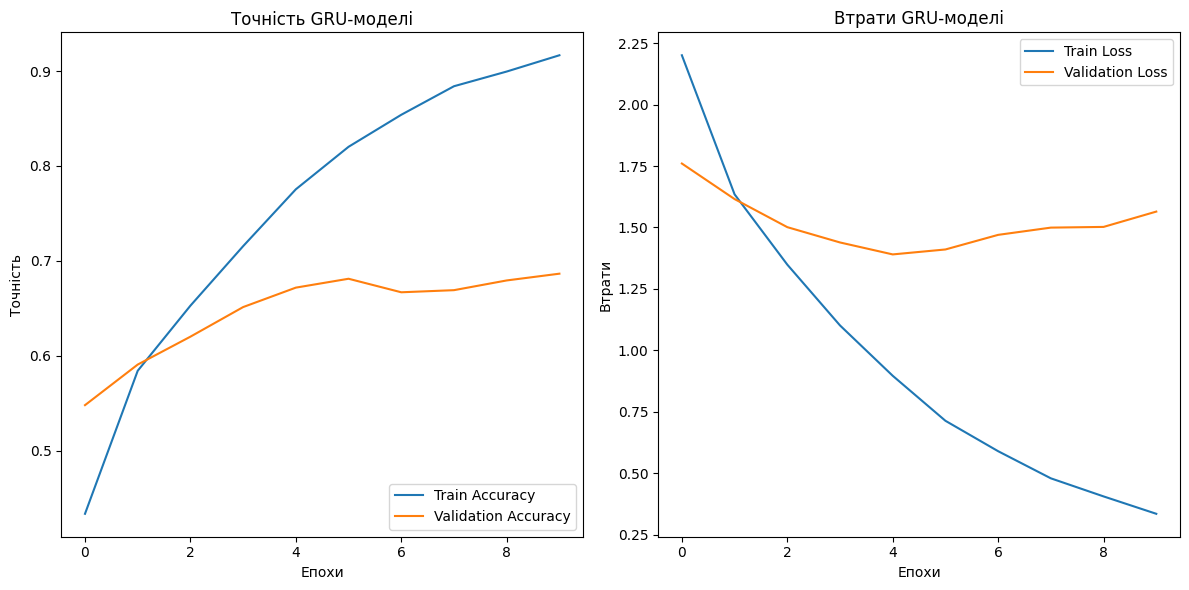

In [22]:
# Графіки точності та втрат для GRU-моделі
plt.figure(figsize=(12, 6))

# Точність
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Точність GRU-моделі')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.legend(loc='lower right')

# Втрата
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Втрати GRU-моделі')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


***Аналіз графіків GRU-моделі***

**Графік точності:**

Тренувальна точність (Train Accuracy) зростає стабільно, досягаючи понад 90% до кінця навчання.
Валідаційна точність (Validation Accuracy) спочатку також зростає, але після 5-ї епохи сповільнюється і майже стабілізується на рівні ~68%. Це вказує на те, що модель починає перенавчатись.

**Графік втрат:**

Тренувальні втрати (Train Loss) значно знижуються, що свідчить про успішне навчання моделі на тренувальних даних.
Валідаційні втрати (Validation Loss) знижуються до 5-ї епохи, а потім починають зростати, що підтверджує перенавчання.

###Крок 8. Порівняння GRU з LSTM

**GRU:**

Швидше навчається і показує трохи кращу точність (69% проти 68% у LSTM).

Має трохи кращу F1-метрику для рідкісних класів, але проблема з низькою продуктивністю для цих класів залишається.

**LSTM:**

Модель трохи повільніша, але також ефективна для цієї задачі.

Обидві моделі мають схожу продуктивність:
GRU трохи швидше тренується і досягає вищої тренувальної точності.
Проте обидві моделі демонструють однакові проблеми із перенавчанням після кількох епох.

##***Висновок***

У межах цієї практичної роботи було реалізовано дві моделі на основі рекурентних нейронних мереж (LSTM та GRU) для класифікації текстів із датасету Reuters. Обидві моделі показали схожу продуктивність із точністю близько 68-69% на тестових даних. Використання GRU дозволило трохи швидше тренувати модель, водночас забезпечуючи аналогічну точність порівняно з LSTM. Однак обидві моделі виявили проблему перенавчання, що спостерігалося у зростанні валідаційних втрат після кількох епох.

Незважаючи на хорошу продуктивність для найпоширеніших класів, моделі продемонстрували низькі результати для рідкісних класів, що пояснюється нерівномірним розподілом даних. Для подальшого покращення рекомендується:

Застосувати техніку раннього стопу (Early Stopping).
Використати ваги класів для врахування дисбалансу даних.
Впровадити попередньо натреновані ембеддинги (наприклад, GloVe), щоб покращити якість класифікації текстів.
Ця робота демонструє базові принципи роботи з рекурентними нейронними мережами та підходи до текстової класифікації, закладаючи основу для подальших вдосконалень.

##**Контрольні питання**
1. Що таке рекурентна нейронна мережа і у чому її основні відмінності
від звичайних нейронних мереж?

RNN — це тип нейронної мережі, яка має зворотні зв'язки, що дозволяють враховувати залежності між елементами послідовності. Вона підходить для роботи з послідовними даними (текст, часоряди), оскільки запам'ятовує інформацію з попередніх кроків. Основна відмінність від звичайних нейронних мереж (FFNN) — обробка даних із врахуванням їх порядку.



2. Які основні проблеми пов'язані з навчанням RNN?

Основні проблеми:

- Зникнення та вибух градієнтів при навчанні на довгих послідовностях.
- Низька ефективність для довготривалих залежностей.
- Високі обчислювальні витрати через послідовну обробку даних.



3. Що таке LSTM та GRU? Які основні відмінності та схожості між ними?

LSTM (Long Short-Term Memory) та GRU (Gated Recurrent Unit) — це вдосконалені типи RNN, які вирішують проблему зникнення градієнтів завдяки використанню спеціальних "вхідних", "забуваючих" та "вихідних" вентилів (gates).

Відмінності:

- LSTM має більше параметрів, включаючи окрему пам'ять (cell state), тоді як GRU простіший, об'єднуючи деякі вентилі.

- GRU працює швидше, але LSTM може краще працювати з довгими залежностями.

Схожості:
- обидва підходять для задач з послідовними даними.



4. У яких задачах рекомендується використовувати RNN?

RNN використовуються для:

- Обробки текстів (класифікація, генерація текстів).
- Перекладу (Neural Machine Translation).
- Аналізу часорядів (прогнозування, аналіз сигналів).
- Розпізнавання мови або звуків.



5. Які існують альтернативи RNN для обробки послідовностей даних?

CNN (Convolutional Neural Networks) — для обробки локальних залежностей у послідовностях.

Трансформери (Transformers) — сучасна альтернатива з механізмом уваги (Attention), наприклад, моделі BERT, GPT.

Традиційні методи: HMM (Hidden Markov Models) та інші статистичні підходи.